In [1]:
import numpy as np
import cv2
import os
from glob import glob
import matplotlib.pyplot as plt
import PIL.Image as Image

from BCS_functions import *
from skimage.io import imread
from skimage import transform
from skimage.measure import label, regionprops
from skimage.filters import threshold_yen
from skimage.feature import peak_local_max

from scipy.stats import pearsonr

import pandas as pd
AOI_KEYWORD = "6x6-CROP"
LOW_PASS_KEYWORD = "LP_Filter"
IMG_SUFFIX = ".tif"
THRESHOLD_METHOD = 90

img_folder = r"C:\Users\qzheng\OneDrive - NREL\BCS Comparison\PSA-CIEMAT\data\Test tracking H1605 to BCS people"
img_files = glob(os.path.join(img_folder, "*" + IMG_SUFFIX))

result_buffer_path = "results"
if not os.path.exists(result_buffer_path):
    os.makedirs(result_buffer_path)

In [2]:
def threshold_wrapper(img, method):
    if type(method) == str and method == "yen":
        return threshold_yen(img)
    
    
    elif type(method) == int:
        quantile_float = method / 100
        quantile_value = np.quantile(img.flatten(), quantile_float)
        return quantile_value
    
    else:
        raise ValueError("Invalid thresholding method. Use 'yen' or an integer value between 0 and 100.")


def NREL_low_pass_filter_comparison(original_img_file_path: str):
    """
    For processing AOI images only
    """
    assert AOI_KEYWORD in original_img_file_path, f"Image file path does not contain {AOI_KEYWORD}"
    img = imread(original_img_file_path)
    original_img_file_lpf_psa = original_img_file_path.replace(IMG_SUFFIX, f" {LOW_PASS_KEYWORD}{IMG_SUFFIX}")
    img_lpf_psa = imread(original_img_file_lpf_psa)
    assert img.shape[0] == 48 # Check if this is the correct image to use
    img_width = img.shape[2]
    img_height = img.shape[1]

    center_x_pos = img_width // 2
    center_y_pos = img_height // 2
    for i in range(img.shape[0]):
        curr_img = img[i]
        curr_img_lpf_psa = img_lpf_psa[i]
        curr_img_lpf_nrel = BCS_functions.low_pass_filter(curr_img, keep_ratio=0.05)

        psa_center_profile_widthwise = curr_img_lpf_psa[center_y_pos, :]
        psa_center_profile_heightwise = curr_img_lpf_psa[:, center_x_pos]
        nrel_center_profile_widthwise = curr_img_lpf_nrel[center_y_pos, :]
        nrel_center_profile_heightwise = curr_img_lpf_nrel[:, center_x_pos]
        original_center_profile_widthwise = curr_img[center_y_pos, :]
        original_center_profile_heightwise = curr_img[:, center_x_pos]

        fig, axs = plt.subplots(2, 3, figsize=(12*2, 8*2))
        fig.suptitle(f"Layer {i}")
        axs[0, 0].plot(psa_center_profile_widthwise, label="PSA", alpha=0.5)
        axs[0, 0].plot(nrel_center_profile_widthwise, label="NREL", alpha=0.5)
        axs[0, 0].plot(original_center_profile_widthwise, label="Original", alpha=0.5)
        axs[0, 0].set_title("Widthwise")
        # axs[0, 0].legend()
        axs[0, 1].plot(psa_center_profile_heightwise, label="PSA", alpha=0.5)
        axs[0, 1].plot(nrel_center_profile_heightwise, label="NREL", alpha=0.5)
        axs[0, 1].plot(original_center_profile_heightwise, label="Original", alpha=0.5)
        axs[0, 1].set_title("Heightwise")
        # axs[0, 1].legend()
        axs[0, 2].axis("off")  # Hide the axes
        handles, labels = axs[0, 0].get_legend_handles_labels()
        axs[0, 2].legend(handles, labels, loc="center")
        

        axs[1, 0].imshow(curr_img, cmap="gray")
        axs[1, 0].set_title("Original")
        axs[1, 0].axis("off")
        axs[1, 1].imshow(curr_img_lpf_psa, cmap="gray")
        axs[1, 1].set_title("PSA")
        axs[1, 1].axis("off")
        axs[1, 2].imshow(curr_img_lpf_nrel, cmap="gray")
        axs[1, 2].set_title("NREL")
        axs[1, 2].axis("off")
        fig.tight_layout()

        # save_figure
        img_save_path = os.path.join(result_buffer_path, "low_pass_comparison", "AOI_images")
        if not os.path.exists(img_save_path):
            os.makedirs(img_save_path)
        img_save_path = os.path.join(img_save_path, f"layer_{i}.png")
        plt.savefig(img_save_path)
        plt.close()

def NREL_low_pass_filter_comparison_full_img(original_img_file_path: str):
    assert AOI_KEYWORD not in original_img_file_path, f"Image file path contains {AOI_KEYWORD}"
    original_img_file_lpf_psa = original_img_file_path.replace(IMG_SUFFIX, f" {LOW_PASS_KEYWORD}{IMG_SUFFIX}")
    img = imread(original_img_file_path)
    img_lpf_psa = imread(original_img_file_lpf_psa)
    assert img.shape[0] == 48 # Check if this is the correct image to use

    src_pts = np.array([[186, 27], [1150, 28], [1149, 991], [183, 993]])
    desired_width = 1000
    dst = np.array([[0, 0], [desired_width, 0], [desired_width, desired_width], [0, desired_width]])
    tform = transform.estimate_transform('projective', dst, src_pts)

    aim_point_x_pos = np.round(1000/12*7).astype(int)
    aim_point_y_pos = np.round(1000/12*(6-1.5)).astype(int)

    for i in range(img.shape[0]):
        curr_img = img[i]
        curr_img_lpf_psa = img_lpf_psa[i]
        curr_img_lpf_nrel = BCS_functions.low_pass_filter(curr_img, keep_ratio=0.05)

        curr_img_psa_target_only = transform.warp(curr_img_lpf_psa, tform, output_shape=(desired_width, desired_width))
        curr_img_nrel_target_only = transform.warp(curr_img_lpf_nrel, tform, output_shape=(desired_width, desired_width))
        curr_img_original_target_only = transform.warp(curr_img, tform, output_shape=(desired_width, desired_width))

        psa_center_profile_widthwise = curr_img_psa_target_only[aim_point_y_pos, :]
        psa_center_profile_heightwise = curr_img_psa_target_only[:, aim_point_x_pos]
        nrel_center_profile_widthwise = curr_img_nrel_target_only[aim_point_y_pos, :]
        nrel_center_profile_heightwise = curr_img_nrel_target_only[:, aim_point_x_pos]
        original_center_profile_widthwise = curr_img_original_target_only[aim_point_y_pos, :]
        original_center_profile_heightwise = curr_img_original_target_only[:, aim_point_x_pos]

        fig, axs = plt.subplots(2, 3, figsize=(12*2, 8*2))
        fig.suptitle(f"Layer {i}")
        axs[0, 0].plot(psa_center_profile_widthwise, label="PSA", alpha=0.5)
        axs[0, 0].plot(nrel_center_profile_widthwise, label="NREL", alpha=0.5)
        axs[0, 0].plot(original_center_profile_widthwise, label="Original", alpha=0.5)
        axs[0, 0].set_title("Widthwise")
        # axs[0, 0].legend()
        axs[0, 1].plot(psa_center_profile_heightwise, label="PSA", alpha=0.5)
        axs[0, 1].plot(nrel_center_profile_heightwise, label="NREL", alpha=0.5)
        axs[0, 1].plot(original_center_profile_heightwise, label="Original", alpha=0.5)
        axs[0, 1].set_title("Heightwise")
        # axs[0, 1].legend()
        axs[0, 2].axis("off")
        handles, labels = axs[0, 0].get_legend_handles_labels()
        axs[0, 2].legend(handles, labels, loc="center")

        axs[1, 0].imshow(curr_img_original_target_only, cmap="gray")
        axs[1, 0].set_title("Original")
        axs[1, 0].axis("off")
        axs[1, 1].imshow(curr_img_psa_target_only, cmap="gray")
        axs[1, 1].set_title("PSA")
        axs[1, 1].axis("off")
        axs[1, 2].imshow(curr_img_nrel_target_only, cmap="gray")
        axs[1, 2].set_title("NREL")
        axs[1, 2].axis("off")
        fig.tight_layout()

        # save_figure
        img_save_path = os.path.join(result_buffer_path, "low_pass_comparison", "Full_images")
        if not os.path.exists(img_save_path):
            os.makedirs(img_save_path)
        img_save_path = os.path.join(img_save_path, f"layer_{i}.png")
        plt.savefig(img_save_path)
        plt.close()


In [21]:
def compute_azimuth_ang_elevation(pointing_vector):
    unit_pointing_vector = pointing_vector / np.linalg.norm(pointing_vector)
    x, y, z = unit_pointing_vector
    azimuth = np.arctan2(y, x) # Convert to degrees
    elevation = np.arctan2(z, np.sqrt(x**2 + y**2)) # Convert to degrees
    return azimuth, elevation


def find_angle_mrad(aim_vec, point_vec):
    
    vec1 = aim_vec
    vec2 = point_vec

    vec1_norm = np.linalg.norm(vec1)
    vec2_norm = np.linalg.norm(vec2)
    cos_theta = np.dot(vec1, vec2) / (vec1_norm * vec2_norm)

    vec_1_azimuth, vec_1_elevation = compute_azimuth_ang_elevation(vec1/np.linalg.norm(vec1))
    vec_2_azimuth, vec_2_elevation = compute_azimuth_ang_elevation(vec2/np.linalg.norm(vec2))

    azimuth_error = vec_1_azimuth - vec_2_azimuth
    elevation_error = vec_1_elevation - vec_2_elevation
    # Added round here to avoid floating point error that cause arccos to return nan

    # azimuth_error = np.arccos(np.round(np.dot(vec_1_azimuth, vec_2_azimuth) / (np.linalg.norm(vec_1_azimuth) * np.linalg.norm(vec_2_azimuth)), decimals=10))
    # if (vec_2_azimuth[0] > vec_1_azimuth[0]):
    #     azimuth_error = -azimuth_error
   
    # elevation_error = np.arccos(np.round(np.dot(vec_1_elevation, vec_2_elevation) / (np.linalg.norm(vec_1_elevation) * np.linalg.norm(vec_2_elevation)), decimals=10))
    # if (vec_2_elevation[2] < vec_1_elevation[2]):
    #     elevation_error = -elevation_error


    return np.arccos(cos_theta) * 1000, azimuth_error * 1000, elevation_error * 1000

def find_beam_center_AOI(original_img_file_path: str, centroid_method: bool):
    """Find the centroid of the AOI images, with FFT low pass filtering"""
    assert AOI_KEYWORD in original_img_file_path, f"Image file path does not contain {AOI_KEYWORD}"
    img = imread(original_img_file_path)
    assert img.shape[0] == 48 # Check if this is the correct image to use
    img_width = img.shape[2]
    img_height = img.shape[1]

    center_x_pos = img_width // 2
    center_y_pos = img_height // 2

    scaling_factor_x = 6 / img_width
    scaling_factor_y = 6 / img_height

    target_center = np.array([-0.008, 6.524, 34.165])
    aiming_point = target_center + np.array([-1, 0, 1.5])
    camera_position = np.array([0, 297.69, 5.26])

    # to_return_df = pd.DataFrame(columns=["Layer", "Beam Center X (m)", "Beam Center Y (m)", "Tracking Error (mrad)", "Tracking Error Elevation Only (mrad)", "Tracking Error Azimuth Only (mrad)"])
    to_return_df = pd.DataFrame(columns=["Layer", "Beam Center X (px)", "Beam Center Y (px)", "Aim Center X (px)", "Aim Center Y (px)", 
                                         "Beam Error X (m)", "Beam Error Y (m)", "Scaling Factor X", "Scaling Factor Y", "Tracking Error (mrad)",
                                        "Tracking Error Elevation Only (mrad)", "Tracking Error Azimuth Only (mrad)"])
    for i in range(img.shape[0]):
        curr_img = img[i]
        curr_img_lpf_nrel = BCS_functions.low_pass_filter(curr_img, keep_ratio=0.05)
        if centroid_method:
            bright_spot_threshold = threshold_wrapper(curr_img_lpf_nrel, method=THRESHOLD_METHOD)
            regionprops_list = regionprops(label(curr_img_lpf_nrel > bright_spot_threshold), 
                                            intensity_image=curr_img_lpf_nrel)
            beam_center_pixel = regionprops_list[0].centroid
        else:
            beam_center_pixel = peak_local_max(curr_img_lpf_nrel, min_distance=10, num_peaks=1)[0]

        beam_error_x_meter = (beam_center_pixel[1] - center_x_pos) * scaling_factor_x
        beam_error_y_meter = (center_y_pos - beam_center_pixel[0]) * scaling_factor_y
        beam_center = aiming_point + np.array([-1*beam_error_x_meter, 0, beam_error_y_meter])

        aiming_point_vector = aiming_point - camera_position
        beam_center_vector = beam_center - camera_position

        tracking_error_mard, tracking_error_azimuth_only_mrad, tracking_error_elevation_only_mrad = find_angle_mrad(aiming_point_vector, beam_center_vector)
        row_data = pd.DataFrame([[i, beam_center_pixel[1], beam_center_pixel[0], center_x_pos, center_y_pos, beam_error_x_meter, beam_error_y_meter,
                                 scaling_factor_x, scaling_factor_y, tracking_error_mard, tracking_error_elevation_only_mrad, tracking_error_azimuth_only_mrad]], 
                                 columns=["Layer", "Beam Center X (px)", "Beam Center Y (px)", "Aim Center X (px)", "Aim Center Y (px)", 
                                         "Beam Error X (m)", "Beam Error Y (m)", "Scaling Factor X", "Scaling Factor Y", "Tracking Error (mrad)",
                                        "Tracking Error Elevation Only (mrad)", "Tracking Error Azimuth Only (mrad)"])
        # row_data = pd.DataFrame([[i, beam_center_x_meter, beam_center_y_meter, tracking_error_mard, tracking_error_elevation_only_mrad, tracking_error_azimuth_only_mrad]], columns=to_return_df.columns)
        to_return_df = pd.concat([to_return_df, row_data], ignore_index=True)

    centroid_x_correlation = pearsonr(to_return_df['Layer'], to_return_df['Beam Error X (m)'])[0]
    centroid_y_correlation = pearsonr(to_return_df['Layer'], to_return_df['Beam Error Y (m)'])[0]
    centroid_tracking_error_correlation = pearsonr(to_return_df['Layer'], to_return_df['Tracking Error (mrad)'])[0]
    centroid_tracking_error_azimuth_correlation = pearsonr(to_return_df['Layer'], to_return_df['Tracking Error Azimuth Only (mrad)'])[0]
    centroid_tracking_error_elevation_correlation = pearsonr(to_return_df['Layer'], to_return_df['Tracking Error Elevation Only (mrad)'])[0]

    to_return_df.loc[0, 'Beam Center X Corr'] = centroid_x_correlation
    to_return_df.loc[0, 'Beam Center Y Corr'] = centroid_y_correlation
    to_return_df.loc[0, 'Tracking Error Corr'] = centroid_tracking_error_correlation
    to_return_df.loc[0, 'Tracking Error Azimuth Corr'] = centroid_tracking_error_azimuth_correlation
    to_return_df.loc[0, 'Tracking Error Elevation Corr'] = centroid_tracking_error_elevation_correlation

    return to_return_df


def find_beam_center_full_img(original_img_file_path: str, centroid_method: bool):
    assert AOI_KEYWORD not in original_img_file_path, f"Image file path contains {AOI_KEYWORD}"
    img = imread(original_img_file_path)
    assert img.shape[0] == 48 # Check if this is the correct image to use

    src_pts = np.array([[186, 27], [1150, 28], [1149, 991], [183, 993]])
    desired_width = 1000
    dst = np.array([[0, 0], [desired_width, 0], [desired_width, desired_width], [0, desired_width]])
    tform = transform.estimate_transform('projective', dst, src_pts)

    
    camera_position = np.array([0, 297.69, 5.26])
    target_center = np.array([-0.008, 6.524, 34.165])
    aiming_point = target_center + np.array([-1, 0, 1.5])


    scaling_factor_x = 12 / desired_width
    scaling_factor_y = 12 / desired_width

    to_return_df = pd.DataFrame(columns=["Layer", "Beam Center X (px)", "Beam Center Y (px)", "Aim Center X (px)", "Aim Center Y (px)", 
                                         "Beam Error X (m)", "Beam Error Y (m)", "Scaling Factor X", "Scaling Factor Y", "Tracking Error (mrad)",
                                        "Tracking Error Elevation Only (mrad)", "Tracking Error Azimuth Only (mrad)"])
    for i in range(img.shape[0]):
        curr_img = img[i]
        curr_img_target_only = transform.warp(curr_img, tform, output_shape=(desired_width, desired_width))
        curr_img_lpf_nrel = BCS_functions.low_pass_filter(curr_img_target_only, keep_ratio=0.05)

        if centroid_method:
            bright_spot_threshold = threshold_wrapper(curr_img_lpf_nrel, method=THRESHOLD_METHOD)
            regionprops_list = regionprops(label(curr_img_lpf_nrel > bright_spot_threshold), 
                                            intensity_image=curr_img_lpf_nrel)
            beam_center_pixel = regionprops_list[0].centroid
        else:
            beam_center_pixel = peak_local_max(curr_img_lpf_nrel, min_distance=10, num_peaks=1)[0]
        beam_error_x_meter = (beam_center_pixel[1] - desired_width/2) * scaling_factor_x
        beam_error_y_meter = (desired_width/2 - beam_center_pixel[0]) * scaling_factor_y
        beam_center = target_center + np.array([-1*beam_error_x_meter, 0, beam_error_y_meter])

        aiming_point_center_x_pixel = (6 + 1)/scaling_factor_x
        aiming_point_center_y_pixel = (6 + 1.5)/scaling_factor_y

        aiming_point_vector = aiming_point - camera_position
        beam_center_vector = beam_center - camera_position
        tracking_error_mard, tracking_error_azimuth_only_mrad, tracking_error_elevation_only_mrad = find_angle_mrad(aiming_point_vector, beam_center_vector)
        
        row_data = pd.DataFrame([[i, beam_center_pixel[1], beam_center_pixel[0], aiming_point_center_x_pixel, aiming_point_center_y_pixel, beam_error_x_meter, beam_error_y_meter,
                                 scaling_factor_x, scaling_factor_y, tracking_error_mard, tracking_error_elevation_only_mrad, tracking_error_azimuth_only_mrad]], columns=to_return_df.columns)
        to_return_df = pd.concat([to_return_df, row_data], ignore_index=True)

    centroid_x_correlation = pearsonr(to_return_df['Layer'], to_return_df['Beam Error X (m)'])[0]
    centroid_y_correlation = pearsonr(to_return_df['Layer'], to_return_df['Beam Error Y (m)'])[0]
    centroid_tracking_error_correlation = pearsonr(to_return_df['Layer'], to_return_df['Tracking Error (mrad)'])[0]
    centroid_tracking_error_azimuth_correlation = pearsonr(to_return_df['Layer'], to_return_df['Tracking Error Azimuth Only (mrad)'])[0]
    centroid_tracking_error_elevation_correlation = pearsonr(to_return_df['Layer'], to_return_df['Tracking Error Elevation Only (mrad)'])[0]

    to_return_df.loc[0, 'Beam Center X Corr'] = centroid_x_correlation
    to_return_df.loc[0, 'Beam Center Y Corr'] = centroid_y_correlation
    to_return_df.loc[0, 'Tracking Error Corr'] = centroid_tracking_error_correlation
    to_return_df.loc[0, 'Tracking Error Azimuth Corr'] = centroid_tracking_error_azimuth_correlation
    to_return_df.loc[0, 'Tracking Error Elevation Corr'] = centroid_tracking_error_elevation_correlation
    return to_return_df

In [4]:
execute_block = False
if execute_block:
    img_of_interest = [img for img in img_files if LOW_PASS_KEYWORD not in img and AOI_KEYWORD in img]
    NREL_low_pass_filter_comparison(img_of_interest[0])

    img_of_interest = [img for img in img_files if LOW_PASS_KEYWORD not in img and AOI_KEYWORD not in img]
    NREL_low_pass_filter_comparison_full_img(img_of_interest[0])

C:\Users\qzheng\AppData\Local\Temp\1\ipykernel_35988\1011743060.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_return_df = pd.concat([to_return_df, row_data], ignore_index=True)
C:\Users\qzheng\AppData\Local\Temp\1\ipykernel_35988\1011743060.py:83: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_return_df = pd.concat([to_return_df, row_data], ignore_index=True)


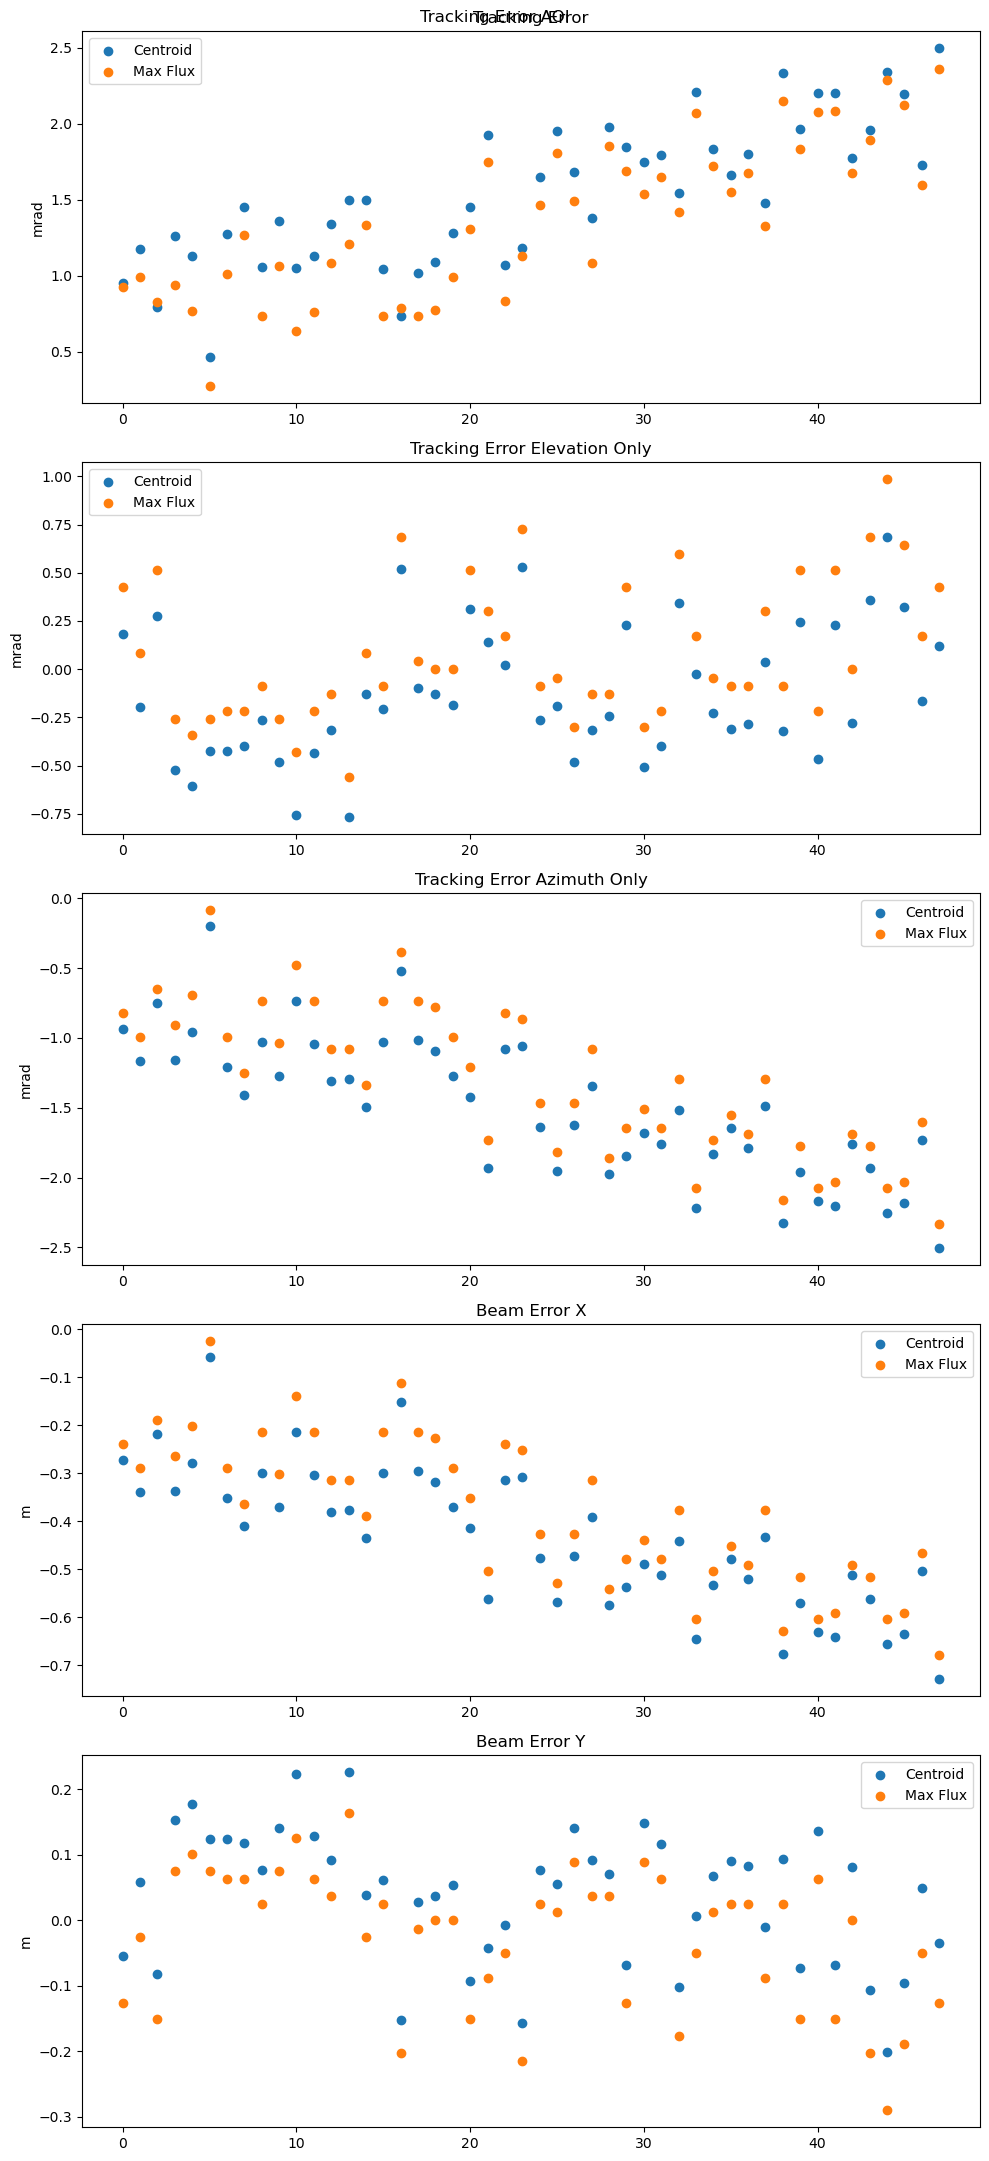

In [29]:
# This analyzes 6x6 image
img_of_interest = [img for img in img_files if LOW_PASS_KEYWORD in img and AOI_KEYWORD in img]
result_df_centroid = find_beam_center_AOI(img_of_interest[0], centroid_method=True)
result_df_centroid_saving_path = os.path.join(result_buffer_path, f"centroid_AOI_{THRESHOLD_METHOD}.csv")
result_df_centroid.to_csv(result_df_centroid_saving_path, index=False)

result_df_max_flux = find_beam_center_AOI(img_of_interest[0], centroid_method=False)
result_df_max_flux_saving_path = os.path.join(result_buffer_path, "max_flux_AOI.csv")
result_df_max_flux.to_csv(result_df_max_flux_saving_path, index=False)


# create a 5x1 scatter plot,
fig, axs = plt.subplots(5, 1, figsize=(10, 22))
fig.suptitle("Tracking Error AOI")
axs[0].scatter(result_df_centroid["Layer"], result_df_centroid["Tracking Error (mrad)"], label="Centroid")
axs[0].scatter(result_df_max_flux["Layer"], result_df_max_flux["Tracking Error (mrad)"], label="Max Flux")
axs[0].legend()
axs[0].set_title("Tracking Error")
axs[0].set_ylabel("mrad")
axs[1].scatter(result_df_centroid["Layer"], result_df_centroid["Tracking Error Elevation Only (mrad)"], label="Centroid")
axs[1].scatter(result_df_max_flux["Layer"], result_df_max_flux["Tracking Error Elevation Only (mrad)"], label="Max Flux")
axs[1].set_title("Tracking Error Elevation Only")
axs[1].legend()
axs[1].set_ylabel("mrad")
axs[2].scatter(result_df_centroid["Layer"], result_df_centroid["Tracking Error Azimuth Only (mrad)"], label="Centroid")
axs[2].scatter(result_df_max_flux["Layer"], result_df_max_flux["Tracking Error Azimuth Only (mrad)"], label="Max Flux")
axs[2].set_title("Tracking Error Azimuth Only")
axs[2].legend()
axs[2].set_ylabel("mrad")
axs[3].scatter(result_df_centroid["Layer"], result_df_centroid["Beam Error X (m)"], label="Centroid")
axs[3].scatter(result_df_max_flux["Layer"], result_df_max_flux["Beam Error X (m)"], label="Max Flux")
axs[3].set_title("Beam Error X")
axs[3].legend()
axs[3].set_ylabel("m")
axs[4].scatter(result_df_centroid["Layer"], result_df_centroid["Beam Error Y (m)"], label="Centroid")
axs[4].scatter(result_df_max_flux["Layer"], result_df_max_flux["Beam Error Y (m)"], label="Max Flux")
axs[4].set_title("Beam Error Y")
axs[4].legend()
axs[4].set_ylabel("m")

fig.tight_layout()
plt.show()
print()

In [ ]:
# display the result_df up to two significant figures
# from IPython.display import display

# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', 1000)  # Prevent line breaks
# pd.set_option('display.float_format', '{:.2f}'.format)  # Format float values

# display(result_df)


C:\Users\qzheng\AppData\Local\Temp\1\ipykernel_35988\1011743060.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_return_df = pd.concat([to_return_df, row_data], ignore_index=True)
C:\Users\qzheng\AppData\Local\Temp\1\ipykernel_35988\1011743060.py:147: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  to_return_df = pd.concat([to_return_df, row_data], ignore_index=True)


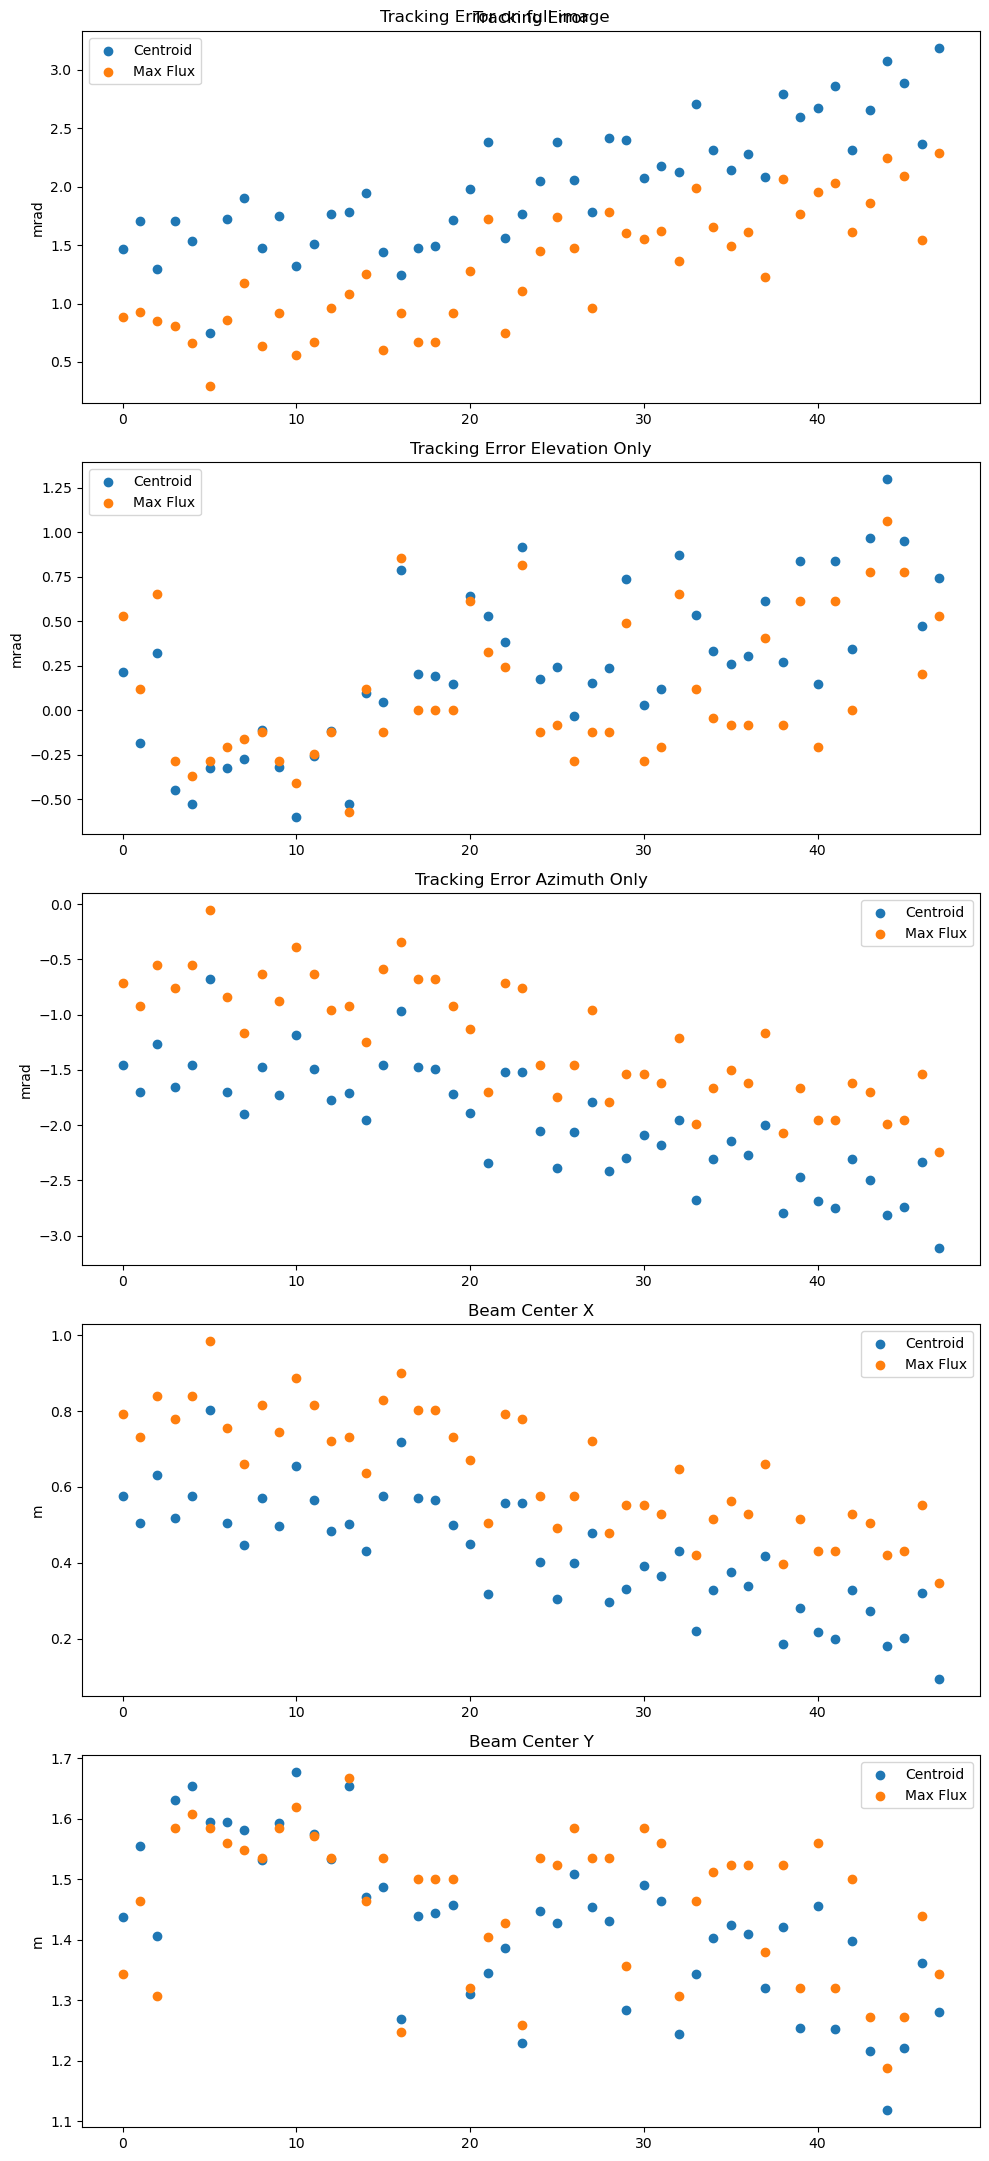

In [25]:
img_of_interest = [img for img in img_files if LOW_PASS_KEYWORD in img and AOI_KEYWORD not in img]
result_df_centroid = find_beam_center_full_img(img_of_interest[0], centroid_method=True)
result_df_centroid_saving_path = os.path.join(result_buffer_path, f"centroid_Full_image_{THRESHOLD_METHOD}.csv")
result_df_centroid.to_csv(result_df_centroid_saving_path, index=False)
result_df_max_flux = find_beam_center_full_img(img_of_interest[0], centroid_method=False)
result_df_max_flux_saving_path = os.path.join(result_buffer_path, "max_flux_Full_image.csv")
result_df_max_flux.to_csv(result_df_max_flux_saving_path, index=False)

# create a 5x1 scatter plot
fig, axs = plt.subplots(5, 1, figsize=(10, 22))
fig.suptitle("Tracking Error on full image")
axs[0].scatter(result_df_centroid["Layer"], result_df_centroid["Tracking Error (mrad)"], label="Centroid")
axs[0].scatter(result_df_max_flux["Layer"], result_df_max_flux["Tracking Error (mrad)"], label="Max Flux")
axs[0].legend()
axs[0].set_title("Tracking Error")
axs[0].set_ylabel("mrad")
axs[1].scatter(result_df_centroid["Layer"], result_df_centroid["Tracking Error Elevation Only (mrad)"], label="Centroid")
axs[1].scatter(result_df_max_flux["Layer"], result_df_max_flux["Tracking Error Elevation Only (mrad)"], label="Max Flux")
axs[1].set_title("Tracking Error Elevation Only")
axs[1].legend()
axs[1].set_ylabel("mrad")
axs[2].scatter(result_df_centroid["Layer"], result_df_centroid["Tracking Error Azimuth Only (mrad)"], label="Centroid")
axs[2].scatter(result_df_max_flux["Layer"], result_df_max_flux["Tracking Error Azimuth Only (mrad)"], label="Max Flux")
axs[2].set_title("Tracking Error Azimuth Only")
axs[2].legend()
axs[2].set_ylabel("mrad")
axs[3].scatter(result_df_centroid["Layer"], result_df_centroid["Beam Error X (m)"], label="Centroid")
axs[3].scatter(result_df_max_flux["Layer"], result_df_max_flux["Beam Error X (m)"], label="Max Flux")
axs[3].set_title("Beam Center X")
axs[3].legend()
axs[3].set_ylabel("m")
axs[4].scatter(result_df_centroid["Layer"], result_df_centroid["Beam Error Y (m)"], label="Centroid")
axs[4].scatter(result_df_max_flux["Layer"], result_df_max_flux["Beam Error Y (m)"], label="Max Flux")
axs[4].set_title("Beam Center Y")
axs[4].legend()
axs[4].set_ylabel("m")
fig.tight_layout()
plt.show()
print()

Centroid of the 6x6 cropped image:  (242.34951114242932, 216.3506562142165)
Maximum intensity point:  [243 224]


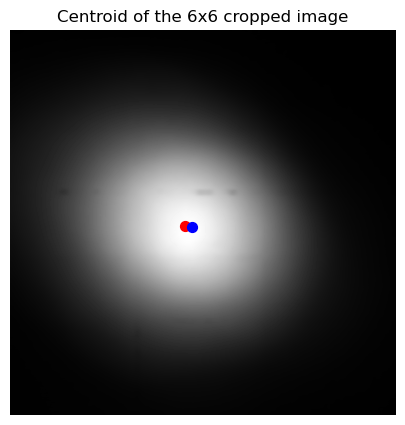

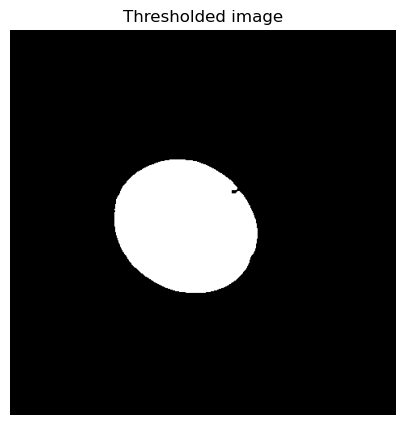

In [30]:
# performing center finding on the 6x6 cropped images
example_img = imread(img_of_interest[0])[0, :, :]
bright_spot_threshold = threshold_wrapper(example_img, method=THRESHOLD_METHOD)
regionprops_list = regionprops(label(example_img > bright_spot_threshold), 
                                intensity_image=example_img)
centroid = regionprops_list[0].centroid

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(example_img, cmap='gray')
ax.scatter(centroid[1], centroid[0], c='r', s=50)
ax.set_title("Centroid of the 6x6 cropped image")
ax.axis('off')

print("Centroid of the 6x6 cropped image: ", centroid)

# finding the maximum intensity point
from skimage.feature import peak_local_max

max_coord = peak_local_max(example_img, min_distance=10, num_peaks=1)[0]
print("Maximum intensity point: ", max_coord)

ax.scatter(max_coord[1], max_coord[0], c='b', s=50)
plt.show()

# showing the threshold image
threshold_img = example_img > bright_spot_threshold
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(threshold_img, cmap='gray')
ax.set_title("Thresholded image")
ax.axis('off')
plt.show()



In [ ]:
# tracking error calculation
# img_center_x = fft_low_passed_dict["AOI_NREL_LPF"].shape[1] / 2
# img_center_y = fft_low_passed_dict["AOI_NREL_LPF"].shape[0] / 2

# scaling_factor_x = 6 / fft_low_passed_dict["AOI_NREL_LPF"].shape[1]
# scaling_factor_y = 6 / fft_low_passed_dict["AOI_NREL_LPF"].shape[0]
# img_center_x_meter = (centroid[1] - img_center_x) * scaling_factor_x
# img_center_y_meter = (img_center_y - centroid[0]) * scaling_factor_y

# target_center = np.array([-0.008, 6.524, 34.165])
# aiming_point = target_center + np.array([-1, 0, 1.5])
# beam_center = aiming_point + np.array([-1*img_center_x_meter, 0, img_center_y_meter])
# camera_position = np.array([0, 297.69, 5.26])

# aiming_point_vector = aiming_point - camera_position
# beam_center_vector = beam_center - camera_position

# # calculate the tracking error with dot product
# aiming_vector_norm = np.linalg.norm(aiming_point_vector)
# beam_vector_norm = np.linalg.norm(beam_center_vector)
# tracking_error = np.arccos(np.dot(aiming_point_vector, beam_center_vector) / (aiming_vector_norm * beam_vector_norm))

# tracking_error_mrad = tracking_error * 1000
# print("Tracking error in mrad: ", tracking_error_mrad)

# beam_center_elevation_only = aiming_point + np.array([0, 0, img_center_y_meter])
# beam_center_vector_elevation_only = beam_center_elevation_only - camera_position
# beam_vector_elevation_only_norm = np.linalg.norm(beam_center_vector_elevation_only)
# tracking_error_elevation_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_elevation_only) / (aiming_vector_norm * beam_vector_elevation_only_norm))
# tracking_error_elevation_only_mrad = tracking_error_elevation_only * 1000
# print("Tracking error in mrad (elevation only): ", tracking_error_elevation_only_mrad)

# beam_center_azimuth_only = aiming_point + np.array([-1*img_center_x_meter, 0, 0])
# beam_center_vector_azimuth_only = beam_center_azimuth_only - camera_position
# beam_vector_azimuth_only_norm = np.linalg.norm(beam_center_vector_azimuth_only)
# tracking_error_azimuth_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_azimuth_only) / (aiming_vector_norm * beam_vector_azimuth_only_norm))
# tracking_error_azimuth_only_mrad = tracking_error_azimuth_only * 1000
# print("Tracking error in mrad (azimuth only): ", tracking_error_azimuth_only_mrad)



In [ ]:
# find centroid on the full image
bright_spot_threshold = (fft_low_passed_dict["Full_NREL_LPF"])
regionprops_list = regionprops(label(fft_low_passed_dict["Full_NREL_LPF"] > bright_spot_threshold), 
                                intensity_image=fft_low_passed_dict["Full_NREL_LPF"])
centroid = regionprops_list[0].centroid

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(fft_low_passed_dict["Full_NREL_LPF"], cmap='gray')
ax.scatter(centroid[1], centroid[0], c='r', s=50)
ax.set_title("Centroid of the full image")
ax.axis('off')
threshold_yen
print("Centroid of the full image: ", centroid)

# finding the maximum intensity point
max_coord = peak_local_max(fft_low_passed_dict["Full_NREL_LPF"], min_distance=10, num_peaks=1)[0]
print("Maximum intensity point: ", max_coord)

ax.scatter(max_coord[1], max_coord[0], c='b', s=50)
plt.show()

In [ ]:
# tracking error calculation
from skimage import transform
src_pts = np.array([[186, 27], [1150, 28], [1149, 991], [183, 993]])
desired_width = 1000
dst = np.array([[0, 0], [desired_width, 0], [desired_width, desired_width], [0, desired_width]])
tform = transform.estimate_transform('projective', dst, src_pts)
rectified = transform.warp(fft_low_passed_dict["Full_NREL_LPF"], tform, output_shape=(desired_width, desired_width))

# visualize
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(rectified, cmap='gray')
ax.set_title("Rectified full image")
ax.axis('off')
plt.show()

In [ ]:
# tracking error estimation on rectified
bright_spot_threshold = threshold_wrapper(rectified, method=THRESHOLD_METHOD)
regionprops_list = regionprops(label(rectified > bright_spot_threshold), 
                                intensity_image=rectified)
centroid = regionprops_list[0].centroid

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(rectified, cmap='gray')
ax.scatter(centroid[1], centroid[0], c='r', s=50)
ax.set_title("Centroid of the rectified full image")
ax.axis('off')

print("Centroid of the rectified full image: ", centroid)

# finding the maximum intensity point
max_coord = peak_local_max(rectified, min_distance=10, num_peaks=1)[0]
print("Maximum intensity point: ", max_coord)

ax.scatter(max_coord[1], max_coord[0], c='b', s=50)
plt.show()

# tracking error calculation

img_center_x = rectified.shape[1] / 2 + rectified.shape[1] / 12 # pointing center is 1m to the right
img_center_y = rectified.shape[0] / 2 - (rectified.shape[0] * 1.5) / 12 # pointing center is 1.5m to the top

scaling_factor_x = 12 / rectified.shape[1]
scaling_factor_y = 12 / rectified.shape[0]

img_center_x_meter = (centroid[1] - img_center_x) * scaling_factor_x
img_center_y_meter = (img_center_y - centroid[0]) * scaling_factor_y

target_center = np.array([-0.008, 6.524, 34.165])
aiming_point = target_center + np.array([-1, 0, 1.5])
beam_center = aiming_point + np.array([-1*img_center_x_meter, 0, img_center_y_meter])
camera_position = np.array([0, 297.69, 5.26])

aiming_point_vector = aiming_point - camera_position
beam_center_vector = beam_center - camera_position

# calculate the tracking error with dot product
aiming_vector_norm = np.linalg.norm(aiming_point_vector)
beam_vector_norm = np.linalg.norm(beam_center_vector)

tracking_error = np.arccos(np.dot(aiming_point_vector, beam_center_vector) / (aiming_vector_norm * beam_vector_norm))
tracking_error_mrad = tracking_error * 1000
print("Tracking error in mrad: ", tracking_error_mrad)

beam_center_elevation_only = aiming_point + np.array([0, 0, img_center_y_meter])
beam_center_vector_elevation_only = beam_center_elevation_only - camera_position
beam_vector_elevation_only_norm = np.linalg.norm(beam_center_vector_elevation_only)

tracking_error_elevation_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_elevation_only) / (aiming_vector_norm * beam_vector_elevation_only_norm))
tracking_error_elevation_only_mrad = tracking_error_elevation_only * 1000
print("Tracking error in mrad (elevation only): ", tracking_error_elevation_only_mrad)

beam_center_azimuth_only = aiming_point + np.array([-1*img_center_x_meter, 0, 0])
beam_center_vector_azimuth_only = beam_center_azimuth_only - camera_position
beam_vector_azimuth_only_norm = np.linalg.norm(beam_center_vector_azimuth_only)

tracking_error_azimuth_only = np.arccos(np.dot(aiming_point_vector, beam_center_vector_azimuth_only) / (aiming_vector_norm * beam_vector_azimuth_only_norm))
tracking_error_azimuth_only_mrad = tracking_error_azimuth_only * 1000
print("Tracking error in mrad (azimuth only): ", tracking_error_azimuth_only_mrad)

